In [1]:
import tensorflow as tf
import tsp_env
import numpy as np
import itertools
import Q_function_graph_model
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
n_cities = 5
T = 4
n_mlp_layers = 2
p = 64
n_dagger_steps = 10; max_steps_per_rollout = 10; 
n_rollouts = 50; n_gradient_steps = 20
learning_rate = 1e-2

In [7]:
obs_ph = tf.placeholder(dtype=tf.float32, shape=[None, n_cities])
expert_act_ph = tf.placeholder(dtype=tf.int32, shape=[None])
adj_ph = tf.placeholder(tf.float32, [None, n_cities, n_cities],
                            name='adj_ph')
graph_weights_ph = tf.placeholder(tf.float32,
                                  [None, n_cities, n_cities],
                                  name='graph_weights_ph')

action_logits_ph = Q_function_graph_model.Q_func(
    obs_ph, adj_ph, graph_weights_ph,
    p=p, T=T, scope='nn_actions',
    initialization_stddev=1e-3,
    reuse=False,
    n_mlp_layers=n_mlp_layers
)

sampled_act_ph = tf.multinomial(action_logits_ph, 1)[0]

loss = -tf.reduce_mean(tf.reduce_sum(tf.multiply(tf.nn.log_softmax(action_logits_ph),
                     tf.one_hot(expert_act_ph, depth=n_cities)), axis = 1))
update_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)

In [8]:
env = tsp_env.TSP_env(5, 0)
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [9]:
data = {'observations': [], 'adj_matrices' : [], 'done': [],
        'weight_matrices': [], 'expert_actions': []}
for i in range(n_dagger_steps):
    # Do n_rollouts rollouts under fitted policy
    rewards = []
    for j in range(n_rollouts):
        n_env_steps = 0
        state = env.reset()
        total_reward = 0
        while True:
            # Get actions suggested by fitted policy and by expert policy 
            action_logits = sess.run(action_logits_ph,
                             feed_dict={obs_ph: state[None],
                                       adj_ph: env.adjacency_matrix[None],
                                       graph_weights_ph: env.weight_matrix[None]})[0]
            actions_ordered = np.argsort(action_logits)[::-1]
            action = 
            for k in range(n_cities):
                if env.binary_vector_state()[actions_ordered[k]] == 0:
                    break
            action = actions_ordered[k]
            
            expert_action = env.best_solution_from_now()[1][0]
            
            # Store data from current step
            data['observations'].append(state)
            data['adj_matrices'].append(env.adjacency_matrix)
            data['weight_matrices'].append(env.weight_matrix)
            data['expert_actions'].append(expert_action)
            
            
            # Step the according to fitted policy
            state, reward, done = env.step(action)
            total_reward += reward
            
            data['done'].append(done)
            
            n_env_steps += 1
            if done or n_env_steps > max_steps_per_rollout:
                break
        rewards.append(total_reward)
        
    print('Mean rollout reward for DAGGER step ', i, ': ', np.mean(rewards))
    
    # Perform training step
    for j in range(n_gradient_steps):
        loss_val, _ = sess.run([loss, update_op],
                          feed_dict={obs_ph: np.array(data['observations']),
                              adj_ph: np.array(data['adj_matrices']),
                              graph_weights_ph: np.array(data['weight_matrices']),
                              expert_act_ph: np.array(data['expert_actions'])})
    print('Loss val at the end of DAGGER step ', i, ': ', loss_val)

Mean rollout reward for DAGGER step  0 :  -2.56556462252
Loss val at the end of DAGGER step  0 :  0.95921
Mean rollout reward for DAGGER step  1 :  -2.50943626172
Loss val at the end of DAGGER step  1 :  0.95658
Mean rollout reward for DAGGER step  2 :  -2.41711421297
Loss val at the end of DAGGER step  2 :  0.956181
Mean rollout reward for DAGGER step  3 :  -2.64410972969
Loss val at the end of DAGGER step  3 :  0.958867
Mean rollout reward for DAGGER step  4 :  -2.50704293022
Loss val at the end of DAGGER step  4 :  0.957216
Mean rollout reward for DAGGER step  5 :  -2.63807069553
Loss val at the end of DAGGER step  5 :  0.957331
Mean rollout reward for DAGGER step  6 :  -2.53148450365
Loss val at the end of DAGGER step  6 :  0.957245
Mean rollout reward for DAGGER step  7 :  -2.66533787951
Loss val at the end of DAGGER step  7 :  0.957059
Mean rollout reward for DAGGER step  8 :  -2.66553042304
Loss val at the end of DAGGER step  8 :  0.957021
Mean rollout reward for DAGGER step  9 

In [ ]:
action_logits = sess.run(action_logits_ph, feed_dict={obs_ph: np.array(data['observations'])[1][None],
                              adj_ph: np.array(data['adj_matrices'])[1][None],
                              graph_weights_ph: np.array(data['weight_matrices'])[1][None],
                              expert_act_ph: np.array(data['expert_actions'])[1][None]})

In [ ]:
env.adjacency_matrix

In [ ]:
env.step(actions_ordered[i])
actions_ordered = np.argsort(action_logits)[0][::-1]
for i in range(n_cities):
    if env.binary_vector_state()[actions_ordered[i]] == 0:
        break
print(actions_ordered[i])
env.best_solution_from_now()

In [10]:
loss_vals = []
for j in range(100):
        loss_val, _ = sess.run([loss, update_op],
                          feed_dict={obs_ph: np.array(data['observations']),
                              adj_ph: np.array(data['adj_matrices']),
                              graph_weights_ph: np.array(data['weight_matrices']),
                              expert_act_ph: np.array(data['expert_actions'])})
        loss_vals.append(loss_val)

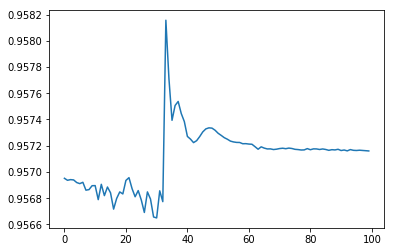

In [11]:
plt.plot(loss_vals)

In [ ]:
data['weight_matrices'][0][0, 1] = 1.5

In [ ]:
sess.run(action_logits_ph,
         feed_dict={obs_ph: np.array(data['observations']),
                    adj_ph: np.array(data['adj_matrices']),
                    graph_weights_ph: np.array(data['weight_matrices']),
                    expert_act_ph: np.array(data['expert_actions'])})

In [ ]:
data['weight_matrices'][0][1, 2] = 3
sess.run(action_logits_ph,
         feed_dict={obs_ph: np.array(data['observations']),
                    adj_ph: np.array(data['adj_matrices']),
                    graph_weights_ph: np.array(data['weight_matrices']),
                    expert_act_ph: np.array(data['expert_actions'])})

In [ ]:
at_random_rewards = []
optimal_rewards = []
for i in range(10000):
    at_random_rewards.append(env.at_random_solution()[0])
    optimal_rewards.append(env.optimal_solution()[0])
print(np.mean(at_random_rewards))
print(np.mean(optimal_rewards))

In [ ]:
def policy_fn(state, env):
    return sess.run()

In [ ]:
env.reset()
print(env.optimal_solution())
env.step(0)
print(env.best_solution_from_now())

In [ ]:
env.reset()
print(env.optimal_solution())
env.step(1)
print(env.best_solution_from_now())

In [ ]:
data['observations'][0:5]

In [ ]:
data['expert_actions'][0:5]

In [ ]:
env.reset()
env.weight_matrix = data['weight_matrices'][0]

In [ ]:
env.optimal_solution()